<a href="https://colab.research.google.com/github/ditorizkyka/Object-Detection-YOLOv11-s/blob/main/YOLOv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue May 20 12:53:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="JCVTFbQ7w0iKfSiD4JtC")
project = rf.workspace("cat-breed").project("cat-breeds-2n7zk")
version = project.version(3)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cat-Breeds-3 in yolov11:: 100%|██████████| 4772/4772 [00:00<00:00, 7359.79it/s]


In [3]:
from pathlib import Path
from shutil import move
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [4]:
root_dir = Path("/content/Cat-Breeds-3")
IMG_SIZE = 224
BATCH_SIZE = 8

In [5]:
# Fungsi untuk baca gambar dan label
def load_image_and_label(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0

    # Baca label YOLO-style: class x_center y_center width height
    label_text = tf.io.read_file(label_path)
    label_lines = tf.strings.strip(tf.strings.split(label_text, '\n'))
    label_elements = tf.strings.split(label_lines)
    label_data = tf.strings.to_number(label_elements, tf.float32)
    label_data = tf.reshape(label_data, [-1, 5])  # [N, 5]

    return image, label_data

In [6]:
# Dataset loader
def create_dataset(image_dir, label_dir):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
    label_files = [os.path.join(label_dir, os.path.basename(f).replace('.jpg', '.txt')) for f in image_files]

    dataset = tf.data.Dataset.from_tensor_slices((image_files, label_files))
    dataset = dataset.map(lambda img, lbl: load_image_and_label(img, lbl), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [7]:
train_dataset = create_dataset("Cat-Breeds-3/train/images", "Cat-Breeds-3/train/labels")
valid_dataset = create_dataset("Cat-Breeds-3/valid/images", "Cat-Breeds-3/valid/labels")

In [8]:
def visualize_sample(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    with open(label_path, 'r') as f:
        lines = f.readlines()

    boxes = []
    for line in lines:
        cls, x_center, y_center, w, h = map(float, line.strip().split())
        x_center *= IMG_SIZE
        y_center *= IMG_SIZE
        w *= IMG_SIZE
        h *= IMG_SIZE

        x_min = x_center - w / 2
        y_min = y_center - h / 2
        boxes.append((x_min, y_min, w, h, int(cls)))

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for (x, y, w, h, cls) in boxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, f"Class {cls}", color='white', backgroundcolor='black', fontsize=8)

    plt.axis('off')
    plt.show()

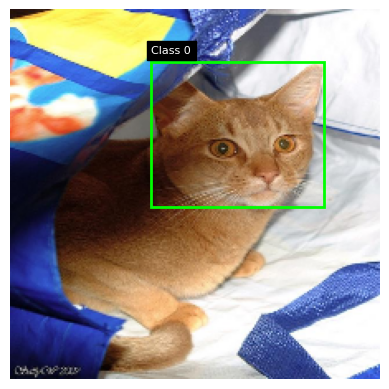

In [9]:
image_path = "/content/Cat-Breeds-3/train/images/Abyssinian_100_jpg.rf.907feb99be55a227a861e538e38fe377.jpg"
label_path = "/content/Cat-Breeds-3/train/labels/Abyssinian_100_jpg.rf.907feb99be55a227a861e538e38fe377.txt"
visualize_sample(image_path, label_path)

In [10]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [1]:
!yolo detect train data=/content/Cat-Breeds-3/data.yaml model=yolo11s.pt epochs=40 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 18.4M/18.4M [00:00<00:00, 118MB/s] 
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Cat-Breeds-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640,

In [3]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=Cat-Breeds-3/valid/images save=True

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs

image 1/476 /content/Cat-Breeds-3/valid/images/Abyssinian_106_jpg.rf.642a61ef7515ae30cb67d89c7b51de88.jpg: 640x640 1 Abyssinian, 22.5ms
image 2/476 /content/Cat-Breeds-3/valid/images/Abyssinian_108_jpg.rf.a73a66887f1f8fbc4527004c68e27acf.jpg: 640x640 1 Abyssinian, 15.7ms
image 3/476 /content/Cat-Breeds-3/valid/images/Abyssinian_111_jpg.rf.bf8857a791eb62a6fb040d285d5aec8a.jpg: 640x640 1 Abyssinian, 15.6ms
image 4/476 /content/Cat-Breeds-3/valid/images/Abyssinian_114_jpg.rf.b4527cc6494042f1bbba326d97a87e6d.jpg: 640x640 1 Abyssinian, 15.6ms
image 5/476 /content/Cat-Breeds-3/valid/images/Abyssinian_119_jpg.rf.4ef255209dab128558b154c7ec8cdaee.jpg: 640x640 1 Abyssinian, 15.6ms
image 6/476 /content/Cat-Breeds-3/valid/images/Abyssinian_124_jpg.rf.e48e427b07f2d842aaa4c7bda7cde3ee.jpg: 640x640 1 Abyssinian, 15.6ms
image 7/476 /con

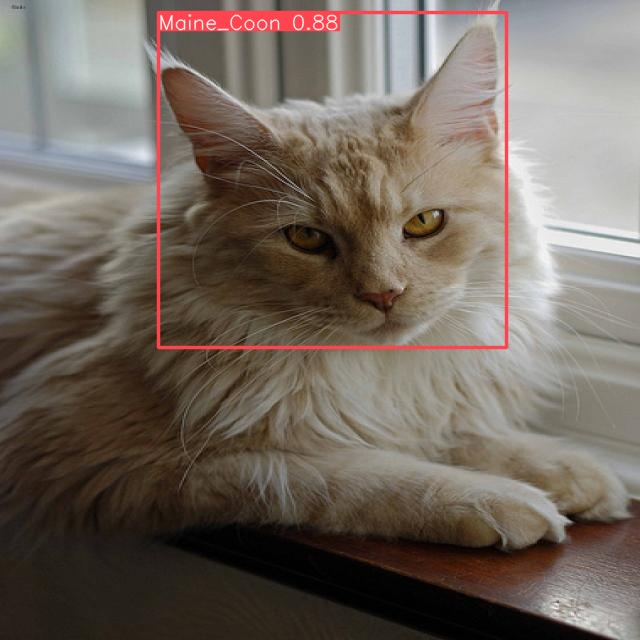

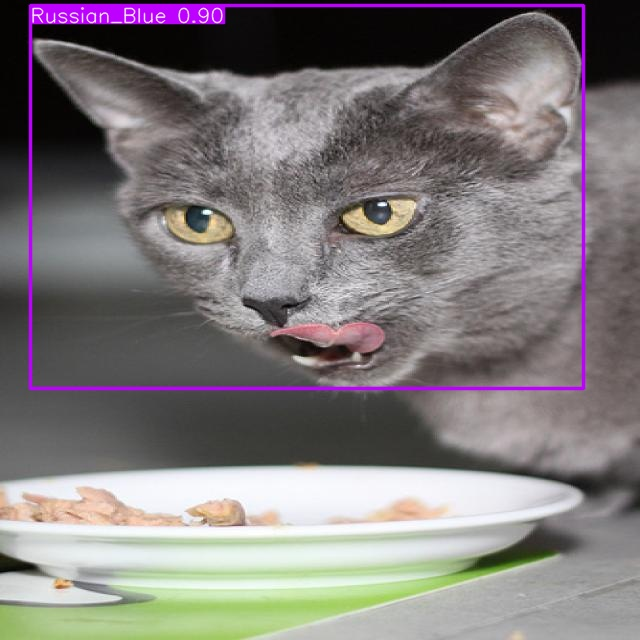

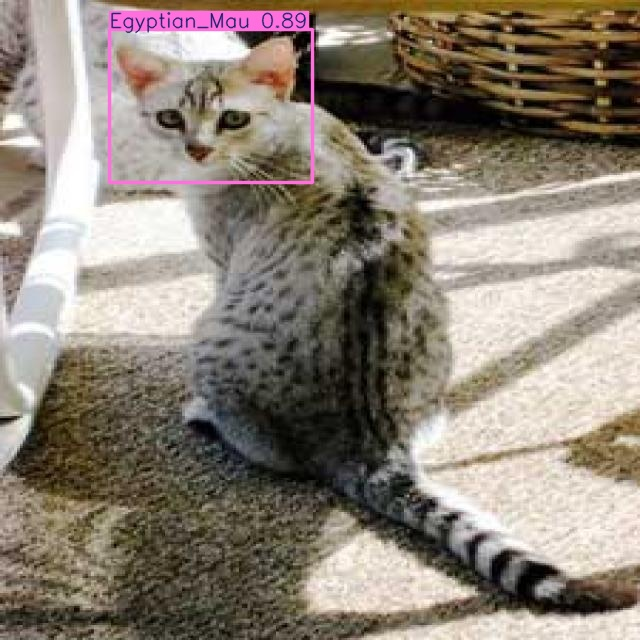

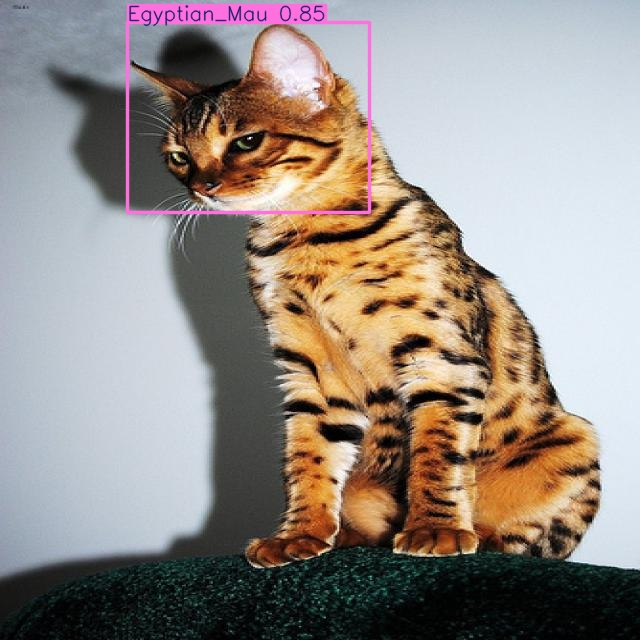

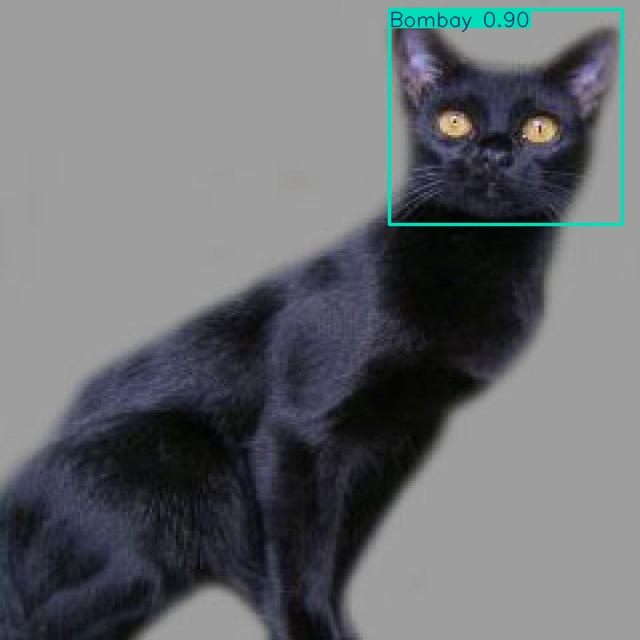

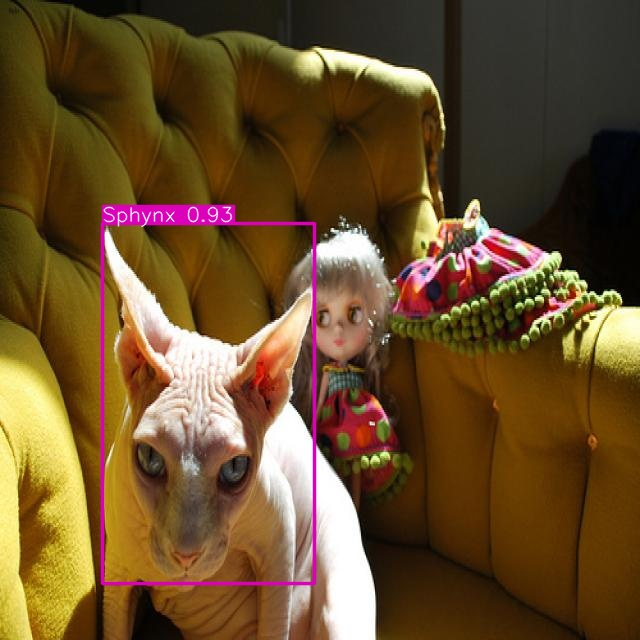

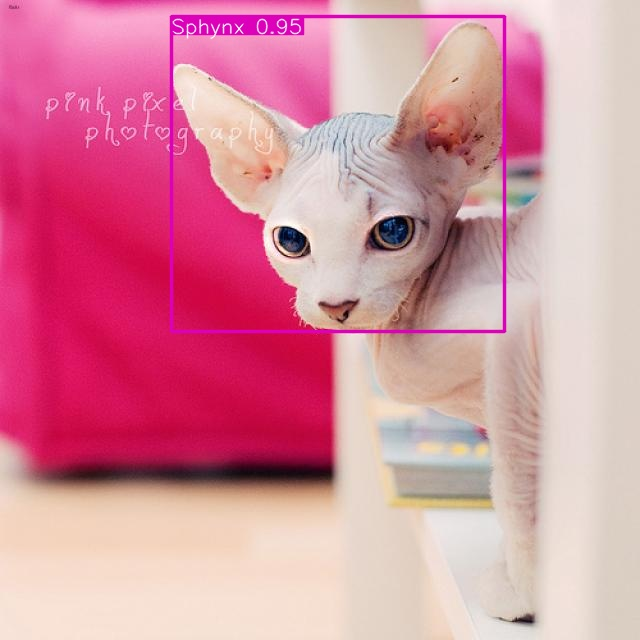

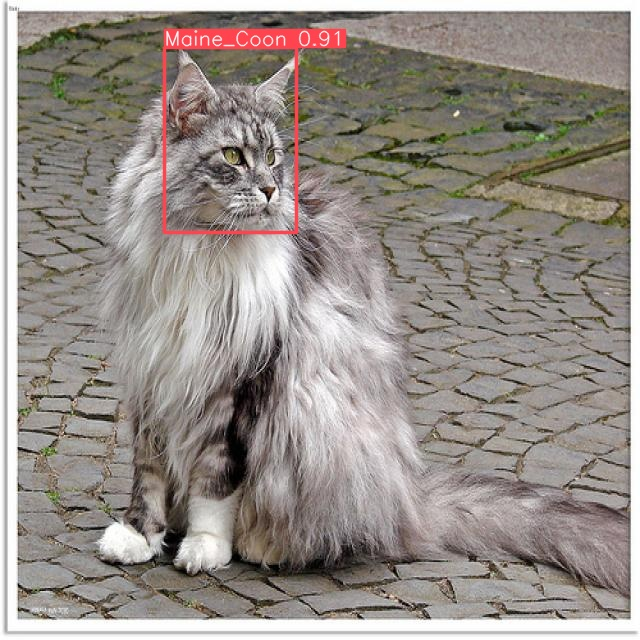

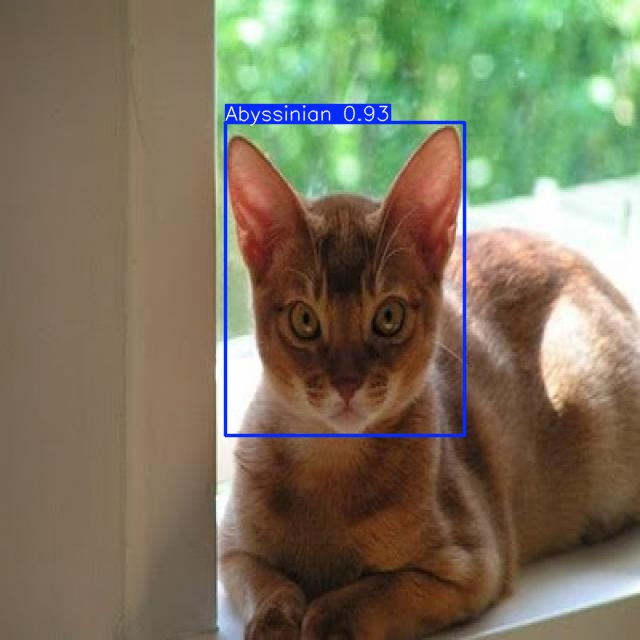

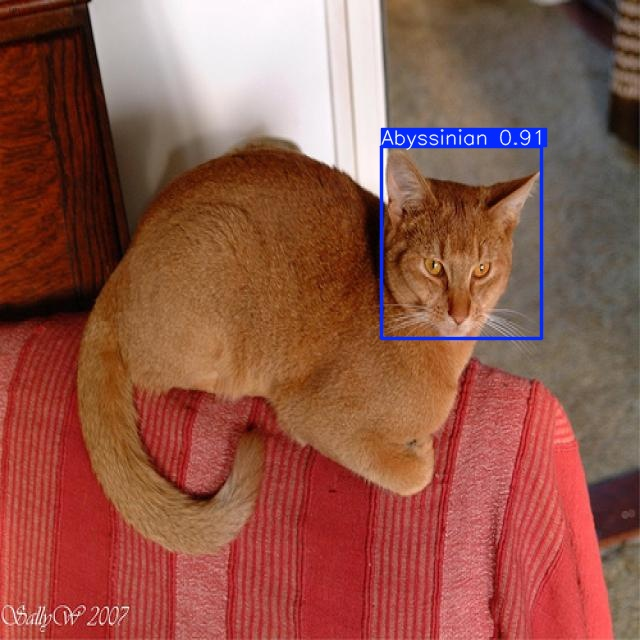

In [4]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


In [5]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/confusion_matrix.png (deflated 18%)
  adding: train/val_batch2_labels.jpg (deflated 6%)
  adding: train/args.yaml (deflated 52%)
  adding: train/results.png (deflated 7%)
  adding: train/F1_curve.png (deflated 6%)
  adding: train/val_batch2_pred.jpg (deflated 6%)
  adding: train/val_batch0_pred.jpg (deflated 8%)
  adding: train/confusion_matrix_normalized.png (deflated 15%)
  adding: train/train_batch2.jpg (deflated 2%)
  adding: train/val_batch1_labels.jpg (deflated 8%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/train_batch0.jpg (deflated 3%)
  adding: train/labels_correlogram.jpg (deflated 42%)
  adding: train/R_curve.png (deflated 8%)
  adding: train/val_batch1_pred.jpg (deflated 7%)
  adding: train/train_batch3152.jpg (deflated 10%)
  adding: train/train_batch1.jpg (deflated 3%)
  add